In [9]:
from google.colab import files


dataset = files.upload()

Saving DataScience_salaries_2024.csv to DataScience_salaries_2024 (1).csv


In [10]:
import pandas as pd
import numpy as np
import io

df = pd.read_csv(io.BytesIO(dataset['DataScience_salaries_2024 (1).csv']))
# save only required columns (work year and USD salary)
df.drop(["experience_level", "employment_type", "job_title", "salary", "salary_currency", "employee_residence", "remote_ratio", "company_location", "company_size"], axis=1, inplace=True)
df.dropna()
print(df)

       work_year  salary_in_usd
0           2021          40038
1           2021          36259
2           2020          35735
3           2021          77364
4           2022          95386
...          ...            ...
14833       2022          15000
14834       2020          15000
14835       2021          15000
14836       2022          15000
14837       2020          15966

[14838 rows x 2 columns]


In [11]:
num_jobs = df['work_year'].value_counts()
print(num_jobs)
# unevenly distributed jobs in terms of time -> implement weighted salary aggregation
# underrepresented years (2020-2022) will be weighted heavier; calculate frequency weights for each year
total_jobs = num_jobs.sum()
weights = total_jobs / (5 * num_jobs)
df["weight"] = df["work_year"].map(weights)
print(df)




work_year
2023    8519
2024    4374
2022    1652
2021     218
2020      75
Name: count, dtype: int64
       work_year  salary_in_usd     weight
0           2021          40038  13.612844
1           2021          36259  13.612844
2           2020          35735  39.568000
3           2021          77364  13.612844
4           2022          95386   1.796368
...          ...            ...        ...
14833       2022          15000   1.796368
14834       2020          15000  39.568000
14835       2021          15000  13.612844
14836       2022          15000   1.796368
14837       2020          15966  39.568000

[14838 rows x 3 columns]


In [12]:
# add timestamps to each job with uniform quarterly distribution to better fit an ARIMA model
np.random.seed(12) # random nums are now reproducible
df["month"] = np.random.choice(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], size=len(df))
# YYYY-Q timestamp format
df["job_date"] = df["work_year"].astype(str) + "-" + df["month"]
# use datetime type
numbered_per_month = {"January": "-01", "February": "-02", "March": "-03", "April": "-04", "May": "-05", "June": "-06", "July": "-07", "August":"-08", "September":"-09", "October": "-10", "November": "-11", "December":"-12"}
df["job_date"] = pd.to_datetime(df["work_year"].astype(str) + df["month"].map(numbered_per_month) + "-01")
# sort over time
df = df.sort_values(by="job_date")
df.drop(["work_year", "month"], axis = 1, inplace = True)
print(df)


       salary_in_usd     weight   job_date
11754          95000  39.568000 2020-01-01
924           260000  39.568000 2020-01-01
14342          54742  39.568000 2020-01-01
101           450000  39.568000 2020-01-01
14462          50180  39.568000 2020-01-01
...              ...        ...        ...
13207          73100   0.678464 2024-12-01
11132         102000   0.678464 2024-12-01
13196          73100   0.678464 2024-12-01
14195          50700   0.678464 2024-12-01
10439         110000   0.678464 2024-12-01

[14838 rows x 3 columns]


In [13]:
# Group by date and compute weighted salary mean
df_grouped = df.groupby("job_date").apply(lambda x: np.average(x["salary_in_usd"], weights=x["weight"])).reset_index()
df_grouped.columns = ["date", "weighted_salary"]

# Display final dataset
print(df_grouped)

         date  weighted_salary
0  2020-01-01    147631.500000
1  2020-02-01     94478.250000
2  2020-03-01     92471.833333
3  2020-04-01     94019.000000
4  2020-05-01    135213.250000
5  2020-06-01     72379.500000
6  2020-07-01     69616.454545
7  2020-08-01    124042.222222
8  2020-09-01     96378.428571
9  2020-10-01     69224.500000
10 2020-11-01     75906.000000
11 2020-12-01    101499.166667
12 2021-01-01     97247.761905
13 2021-02-01     69463.500000
14 2021-03-01     89935.307692
15 2021-04-01    107541.714286
16 2021-05-01     91186.500000
17 2021-06-01    106586.875000
18 2021-07-01    120167.125000
19 2021-08-01     92305.222222
20 2021-09-01     98123.333333
21 2021-10-01     90691.600000
22 2021-11-01    103970.827586
23 2021-12-01    121415.181818
24 2022-01-01    135270.298701
25 2022-02-01    133465.808696
26 2022-03-01    137456.828358
27 2022-04-01    138636.760000
28 2022-05-01    133984.187970
29 2022-06-01    141798.721429
30 2022-07-01    138052.035971
31 2022-

<ipython-input-13-17eecffc6f37>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df.groupby("job_date").apply(lambda x: np.average(x["salary_in_usd"], weights=x["weight"])).reset_index()


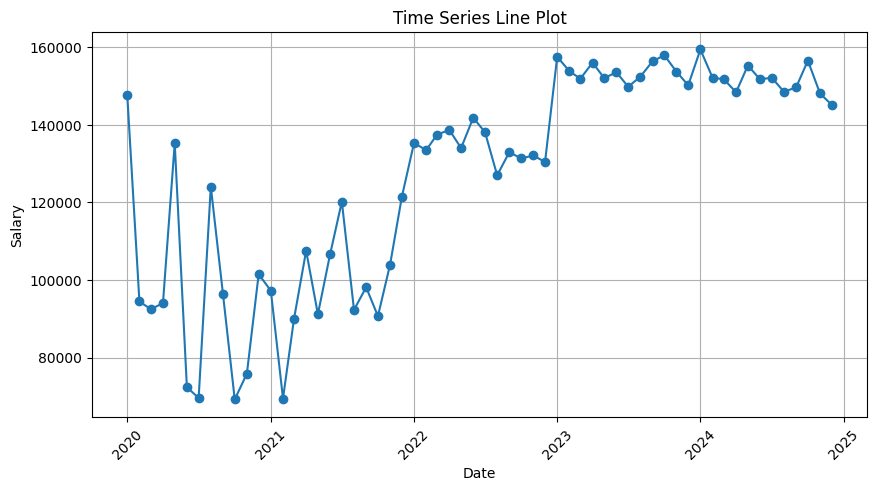

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(df_grouped['date'], df_grouped['weighted_salary'], marker='o', linestyle='-')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Salary')
plt.title('Time Series Line Plot')
plt.xticks(rotation=45)
plt.grid()